# Forest plots

In [1]:
import os
import re
import pandas as pd
import numpy as np
import requests
import time
import json

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
def create_forestplot(
    df, studies,
    labels_col, effect_sizes_col, ci_low_col, ci_high_col,
    stats_cols
):

    # Create a figure with two axes
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(5, 2), gridspec_kw={'width_ratios': [1.5, 2]},sharey=True)

    # Horizontal line at 0 for the null effect
    ax.axvline(x=0, color='k', linestyle='--')
    
    df["ci_low_error"] = df[effect_sizes_col] - df[ci_low_col]
    df["ci_high_error"] =  df[ci_high_col] - df[effect_sizes_col]
    
    ### main plot ###
    # Plotting the effect sizes with different markers per category
    last_offset = 0
    for i, study in enumerate(df[labels_col].unique()):
        effect_size = df.loc[(df[labels_col]==study), effect_sizes_col].values[0]
        ci_low_error = df.loc[(df[labels_col]==study), "ci_low_error"].values[0]
        ci_high_error = df.loc[(df[labels_col]==study), "ci_high_error"].values[0]
        errors = np.array([ci_low_error, ci_high_error]).reshape(2, 1)
        # Plot each category with a different marker
        ax.errorbar(effect_size, i+last_offset*0.25, xerr=[[ci_low_error], [ci_high_error]], fmt="o", color="k", capsize=2.5)

        # Place the study name above the group of categories
        ax.text(min(df[ci_low_col])-2, i+last_offset, study, ha='center', va='center', fontweight='normal', style="italic")

        
    ax.text(min(df[ci_low_col])-2, -1, "Proteins", ha='center', va='center', fontweight='normal')
    
    # Invert the y-axis so the studies are from top to bottom
    ax.invert_yaxis()

    # Customize the left axis: remove yticks but keep the ytick labels for study names
    ax.set_yticks([])
    ax.tick_params(axis='y', which='both', length=0) 


    # Labels for axes
    ax.set_xlabel('Effect Size')
    # ax.set_title('Forest Plot')
    # Remove top, right, and left spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    last_offset = 0

    for i, study in enumerate(df[labels_col].unique()):
        for s, st_col in enumerate(stats_cols):
            stat = df.loc[(df[labels_col]==study), st_col].values[0]
            ax2.text(0.1+0.5*s,i+last_offset*0.25, f"{stat}", va='center', ha="center")
            if i==0:
                if s<len(labels_col):
                    ax2.text(0.1+0.5*s, -1, f"{st_col.lstrip('formatted_')}", va='center', ha="center")

    # Remove the spines and ticks for ax2
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    # ax2.set_title('Statistics')

    plt.tight_layout()
    return fig


In [3]:
protein_coef_df = pd.read_csv("../data/proteomics/assoc_protein_gene_carrier.csv.gz")

In [4]:
protein_coef_df

,protein,coef,se,ci_low,ci_high,p_value,stat,nobs,ncarrier,gene
0,LECT2,1.266139,0.292291,0.693242,1.839036,0.000015,4.331769,42214.0,10,SLTM
1,CD276,2.211144,0.481721,1.266966,3.155322,0.000004,4.590097,48847.0,4,BSN
2,NCAN,-0.668971,0.154042,-0.970895,-0.367047,0.000014,-4.342786,49284.0,37,GIGYF1
3,ODAM,-0.755516,0.171796,-1.092239,-0.418794,0.000011,-4.397751,47679.0,37,GIGYF1
4,CD164,0.514831,0.108810,0.301562,0.728099,0.000002,4.731470,48877.0,85,BLTP1
5,TNFSF12,0.482567,0.106399,0.274024,0.691111,0.000006,4.535443,49397.0,85,BLTP1


In [5]:
def p_value_formatter(pval):
    if pval==0:
        pval = "0"
    else:
        pval = f"{pval:.2e}"
        pval = pval.replace("e", "x10")
        # base, exponent = pval.split("^")
        # pval = f"{base}$^{{{exponent}}}$"
        # #pval = f"{base}$^{exponent}$"
    return pval

protein_coef_df["formatted_coef"] = protein_coef_df.coef.apply(lambda x: f"{x:.2f}")
protein_coef_df["formatted_ci"] = "(" + protein_coef_df.ci_low.apply(lambda x: f"{x:.2f}") + ", " + protein_coef_df.ci_high.apply(lambda x: f"{x:.2f}") + ")"
protein_coef_df["formatted_se"] = protein_coef_df.se.apply(lambda x: f"{x:.2f}")
protein_coef_df["formatted_stat"] = protein_coef_df.stat.apply(lambda x: f"{x:.2f}")
protein_coef_df["formatted_p_value"] = protein_coef_df.p_value.apply(p_value_formatter)
protein_coef_df["Beta (95% CI)"] = protein_coef_df.apply(lambda ser: f"{ser.formatted_coef} {ser.formatted_ci}", axis=1)

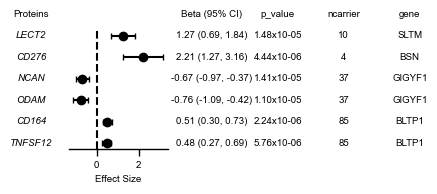

In [6]:
f = create_forestplot(protein_coef_df, protein_coef_df.protein.unique(),
    labels_col="protein", effect_sizes_col="coef", ci_low_col="ci_low", ci_high_col="ci_high",
    stats_cols=["Beta (95% CI)", "formatted_p_value", "ncarrier", "gene"]
)

In [7]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return
    

In [8]:
save_pdf("../data/proteomics/assoc_protein_gene_carrier.pdf", f)

In [4]:
protein_bmi_coef_df = pd.read_csv("../data/proteomics/protein_bmi_assoc.csv.gz")

In [10]:
protein_bmi_coef_df["formatted_coef"] = protein_bmi_coef_df.coef.apply(lambda x: f"{x:.2f}")
protein_bmi_coef_df["formatted_ci"] = "(" + protein_bmi_coef_df.ci_low.apply(lambda x: f"{x:.2f}") + ", " + protein_bmi_coef_df.ci_high.apply(lambda x: f"{x:.2f}") + ")"
protein_bmi_coef_df["formatted_se"] = protein_bmi_coef_df.se.apply(lambda x: f"{x:.2f}")
protein_bmi_coef_df["formatted_stat"] = protein_bmi_coef_df.stat.apply(lambda x: f"{x:.2f}")
protein_bmi_coef_df["formatted_p_value"] = protein_bmi_coef_df.p_value.apply(p_value_formatter)
protein_bmi_coef_df["Beta (95% CI)"] = protein_bmi_coef_df.apply(lambda ser: f"{ser.formatted_coef} {ser.formatted_ci}", axis=1)

In [11]:
def create_forestplot(
    df, studies,
    labels_col, effect_sizes_col, ci_low_col, ci_high_col,
    stats_cols
):

    # Create a figure with two axes
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(4.5, 2), gridspec_kw={'width_ratios': [1.5, 2]},sharey=True)

    # Horizontal line at 0 for the null effect
    ax.axvline(x=0, color='k', linestyle='--')
    
    df["ci_low_error"] = df[effect_sizes_col] - df[ci_low_col]
    df["ci_high_error"] =  df[ci_high_col] - df[effect_sizes_col]
    
    ### main plot ###
    # Plotting the effect sizes with different markers per category
    last_offset = 0
    for i, study in enumerate(df[labels_col].unique()):
        effect_size = df.loc[(df[labels_col]==study), effect_sizes_col].values[0]
        ci_low_error = df.loc[(df[labels_col]==study), "ci_low_error"].values[0]
        ci_high_error = df.loc[(df[labels_col]==study), "ci_high_error"].values[0]
        errors = np.array([ci_low_error, ci_high_error]).reshape(2, 1)
        # Plot each category with a different marker
        ax.errorbar(effect_size, i+last_offset*0.25, xerr=[[ci_low_error], [ci_high_error]], fmt="o", color="k", capsize=5)

        # Place the study name above the group of categories
        ax.text(min(df[ci_low_col])-0.2, i+last_offset, study, ha='center', va='center', fontweight='normal', style="italic")

        
    ax.text(min(df[ci_low_col])-0.2, -1, "Proteins", ha='center', va='center', fontweight='normal')
    
    # Invert the y-axis so the studies are from top to bottom
    ax.invert_yaxis()

    # Customize the left axis: remove yticks but keep the ytick labels for study names
    ax.set_yticks([])
    ax.tick_params(axis='y', which='both', length=0) 


    # Labels for axes
    ax.set_xlabel('Effect Size')
    # ax.set_title('Forest Plot')
    # Remove top, right, and left spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    last_offset = 0

    for i, study in enumerate(df[labels_col].unique()):
        for s, st_col in enumerate(stats_cols):
            stat = df.loc[(df[labels_col]==study), st_col].values[0]
            ax2.text(0.1+0.5*s,i+last_offset*0.25, f"{stat}", va='center', ha="center")
            if i==0:
                if s<len(labels_col):
                    ax2.text(0.1+0.5*s, -1, f"{st_col.lstrip('formatted_')}", va='center', ha="center")

    # Remove the spines and ticks for ax2
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    # ax2.set_title('Statistics')

    plt.tight_layout()
    return fig


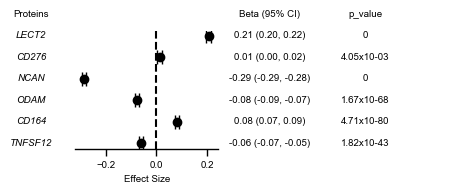

In [12]:
f = create_forestplot(protein_bmi_coef_df, protein_bmi_coef_df.protein.unique(),
    labels_col="protein", effect_sizes_col="coef", ci_low_col="ci_low", ci_high_col="ci_high",
    stats_cols=["Beta (95% CI)", "formatted_p_value"]
)


In [13]:
save_pdf("../data/proteomics/protein_bmi_assoc.pdf", f)